<a href="https://colab.research.google.com/github/Suhas-S63/PLLM_Lab_Exercises/blob/main/Suhas_S_563_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q&A Chatbot using Mistral 7B

### Few Key Advantages of this model are:
* Outperforms Llama
* Approaches CodeLlama 7B performance on code, while remaining good at English tasks
* Uses Grouped-query attention (GQA) for faster inference
* Uses Sliding Window Attention (SWA) to handle longer sequences at smaller cost

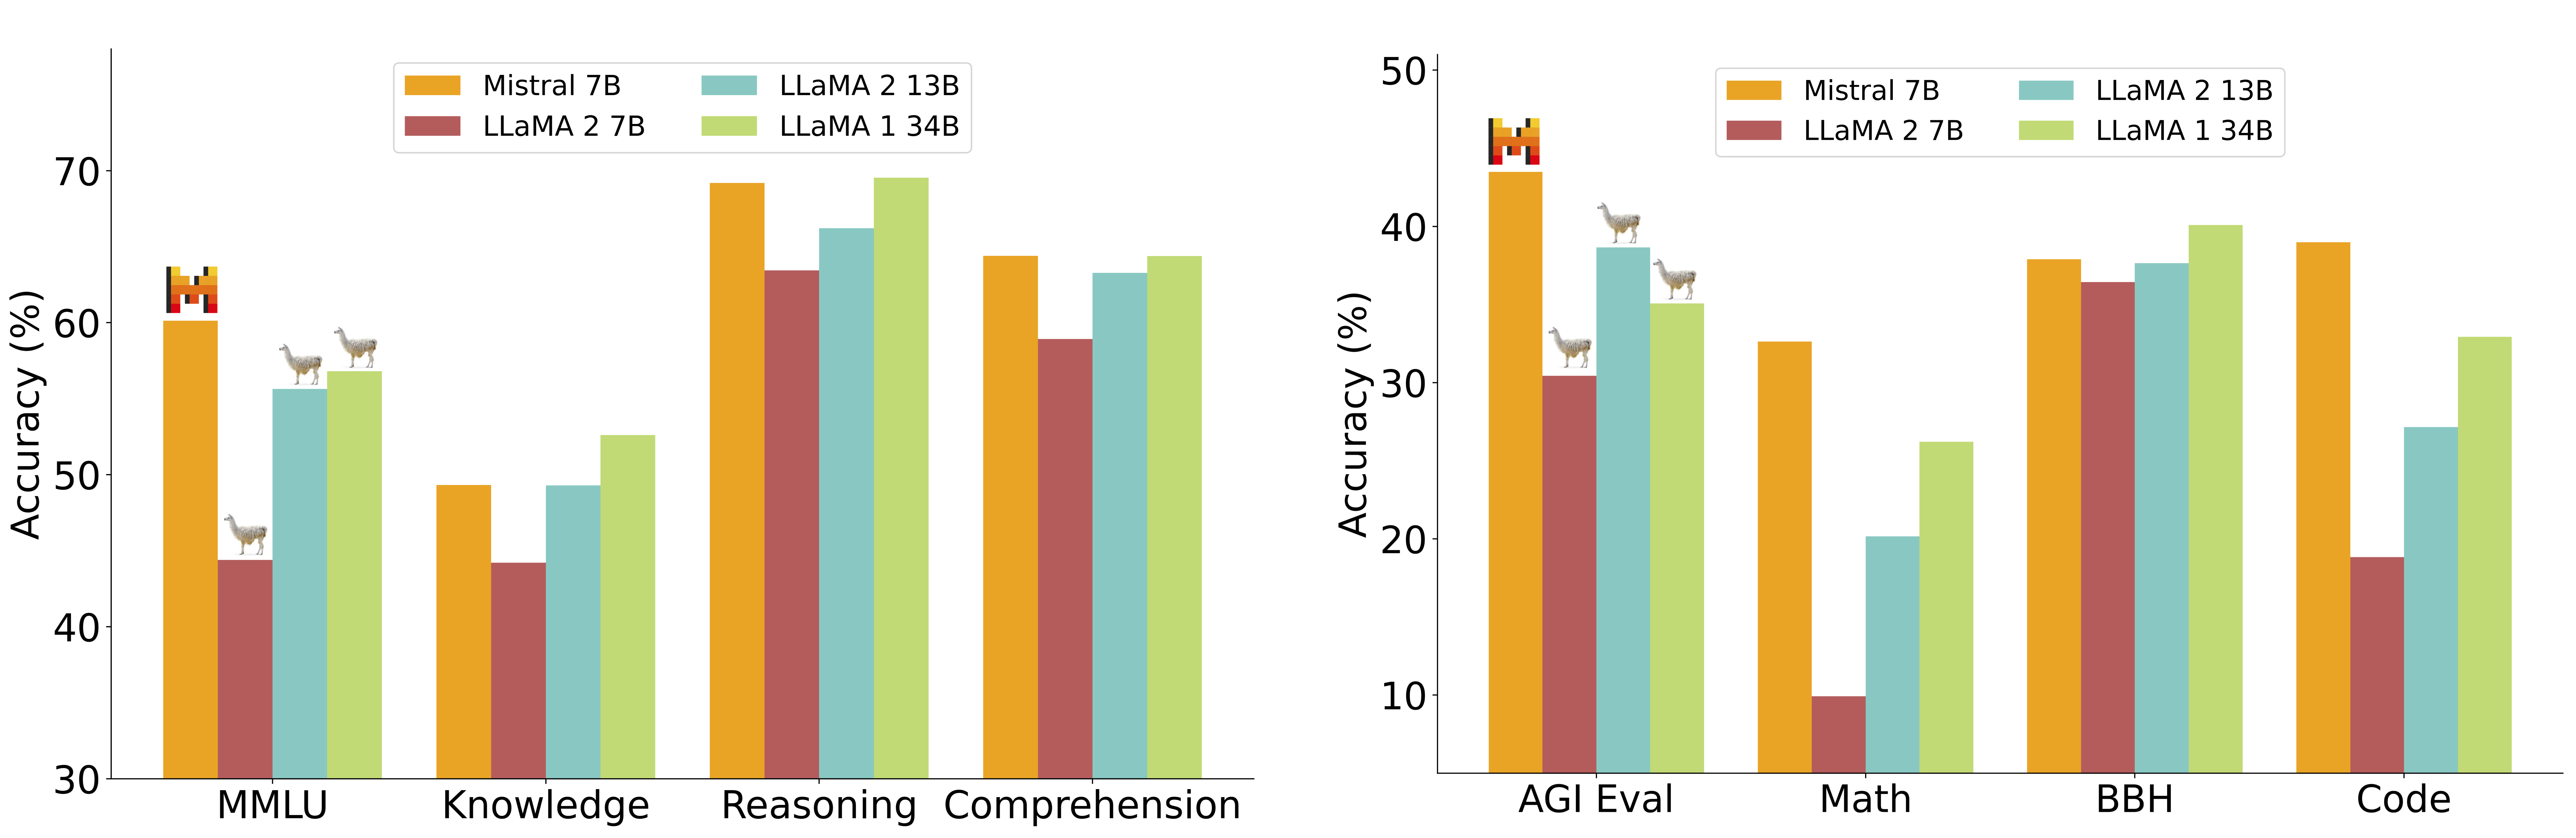

In [1]:
#Installing transformers and other dependencies from huggingface
! pip install accelerate peft bitsandbytes git+https://github.com/huggingface/transformers trl py7zr auto-gptq optimum

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-dpw4bwzq
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-dpw4bwzq
  Resolved https://github.com/huggingface/transformers to commit c54af4c77ed5d72ddcb79d0cc4804d97f21deabc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
#Login to huggingface
from huggingface_hub import notebook_login
notebook_login()

In [3]:
#Import all necessary libraries
import torch
from datasets import load_dataset, Dataset
from peft import LoraConfig, AutoPeftModelForCausalLM, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, TrainingArguments
from trl import SFTTrainer
import os

data = load_dataset("tatsu-lab/alpaca", split="train")#Loading dataset from huggingface repo
data_df = data.to_pandas()#convert it to pandas to faster execution
data_df = data_df[:5000]
data_df["text"] = data_df[["input", "instruction", "output"]].apply(lambda x: "###Human: " + x["instruction"] + " " + x["input"] + " ###Assistant: "+ x["output"], axis=1)
data = Dataset.from_pandas(data_df)#converting to hugging face dataset


tokenizer = AutoTokenizer.from_pretrained("TheBloke/Mistral-7B-Instruct-v0.1-GPTQ")#importing model from TheBloke repo
tokenizer.pad_token = tokenizer.eos_token


quantization_config_loading = GPTQConfig(bits=4, disable_exllama=True, tokenizer=tokenizer)
model = AutoModelForCausalLM.from_pretrained(
                            "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ",
                            quantization_config=quantization_config_loading,
                            device_map="auto"
                        )

#Configurations before training
model.config.use_cache=False #Not inferencing but training
model.config.pretraining_tp=1 #replicate the performance of pretraining
model.gradient_checkpointing_enable() #enaable gradient checkpointing
model = prepare_model_for_kbit_training(model) #prepare model for kbit training

#Lora is used to finetune the original weights
peft_config = LoraConfig(
    r=16, lora_alpha=16, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM", target_modules=["q_proj", "v_proj"]
)
model = get_peft_model(model, peft_config)


training_arguments = TrainingArguments(
        output_dir="mistral-finetuned-alpaca",
        per_device_train_batch_size=8,
        gradient_accumulation_steps=1,
        optim="paged_adamw_32bit",
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        save_strategy="epoch",
        logging_steps=100,
        num_train_epochs=1,
        max_steps=250,
        fp16=True,
        push_to_hub=True
)


trainer = SFTTrainer(
        model=model,
        train_dataset=data,
        peft_config=peft_config,
        dataset_text_field="text",
        args=training_arguments,
        tokenizer=tokenizer,
        packing=False,
        max_seq_length=512
)


trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.


config.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:167: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.However, loading attributes (e.g. ['use_cuda_fp16', 'use_exllama', 'max_input_length', 'exllama_config', 'disable_exllama']) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4568: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:408: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=250, training_loss=1.3194510955810548, metrics={'train_runtime': 1401.8911, 'train_samples_per_second': 1.427, 'train_steps_per_second': 0.178, 'total_flos': 311794752946176.0, 'train_loss': 1.3194510955810548, 'epoch': 0.4})

In [4]:
! cp -r /content/mistral-finetuned-alpaca /content/drive/MyDrive/

cp: cannot create directory '/content/drive/MyDrive/': No such file or directory


# Inference

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from peft import AutoPeftModelForCausalLM
from transformers import GenerationConfig
from transformers import AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained("/content/mistral-finetuned-alpaca")

inputs = tokenizer("""Human: What is difference between Decriminative AI and Generative AI? """, return_tensors="pt").to("cuda")

In [7]:
model = AutoPeftModelForCausalLM.from_pretrained(
    "/content/mistral-finetuned-alpaca",
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="cuda")

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4568: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


In [8]:
generation_config = GenerationConfig(
    do_sample=True,
    top_k=1,
    temperature=0.1,
    max_new_tokens=100,
    pad_token_id=tokenizer.eos_token_id
)

In [9]:
import time
st_time = time.time()
outputs = model.generate(**inputs, generation_config=generation_config)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
print(time.time()-st_time)

Human: What is difference between Decriminative AI and Generative AI? 
AI: Decriminative AI is a type of AI that is used to analyze and classify data. It is used to identify patterns and make predictions based on the data. Generative AI, on the other hand, is a type of AI that is used to generate new data. It is used to create new content, such as images, videos, and music. Generative AI is more creative and can be used to create more complex and sophisticated content.
107.03945183753967


## Prompt1: Christ University is?

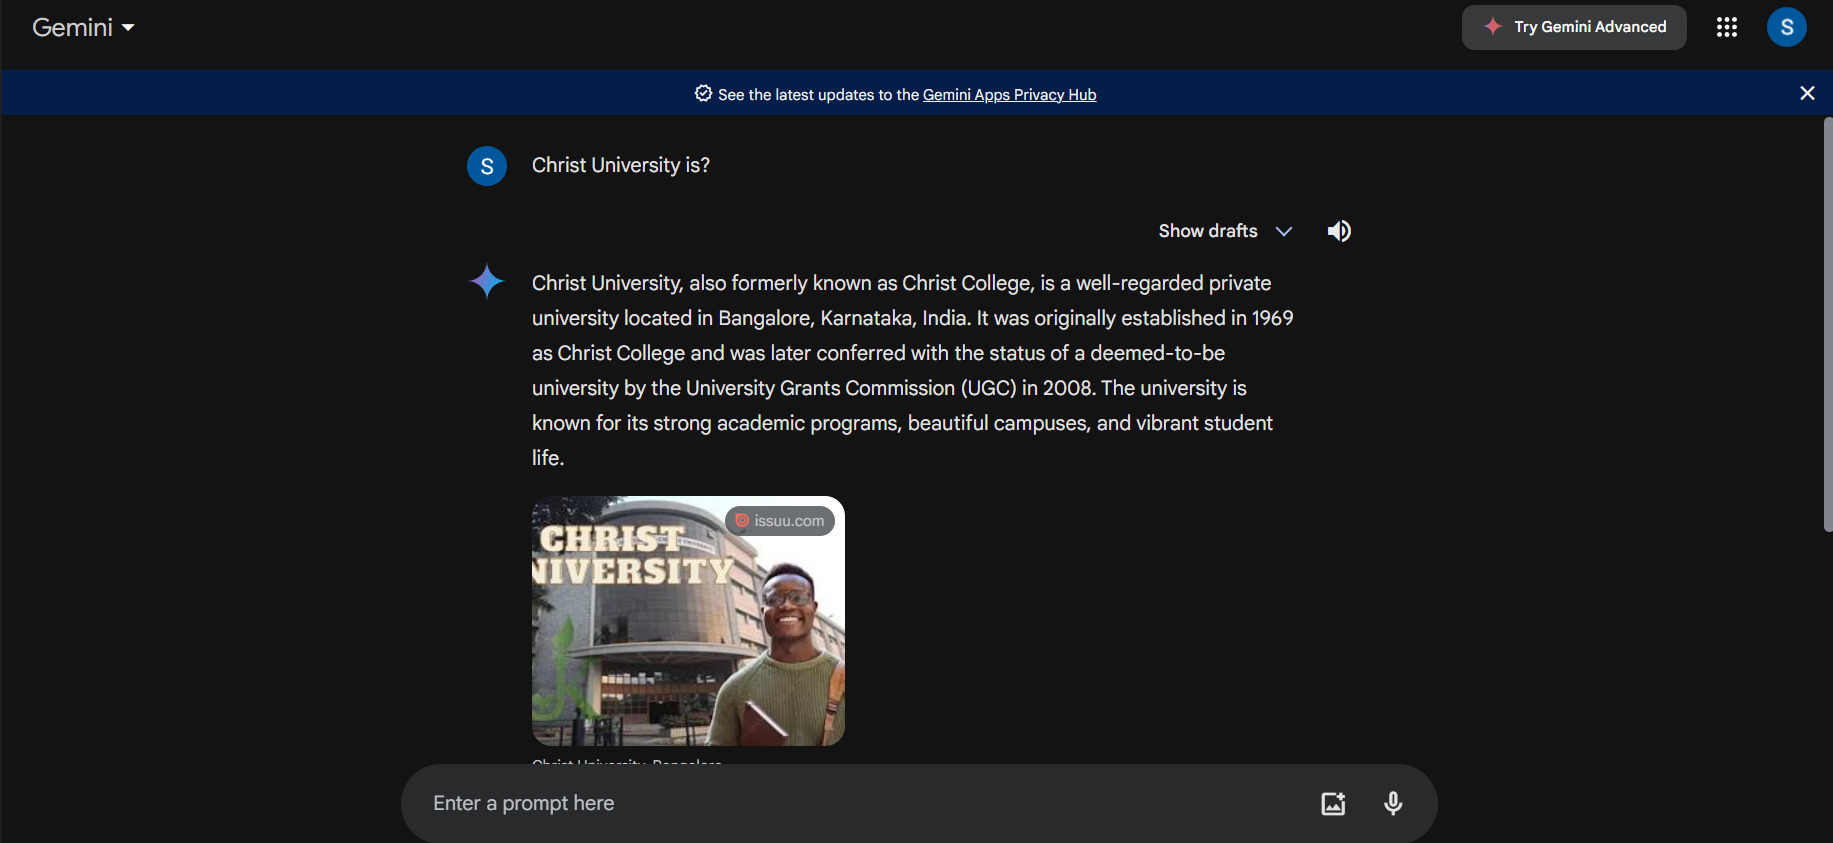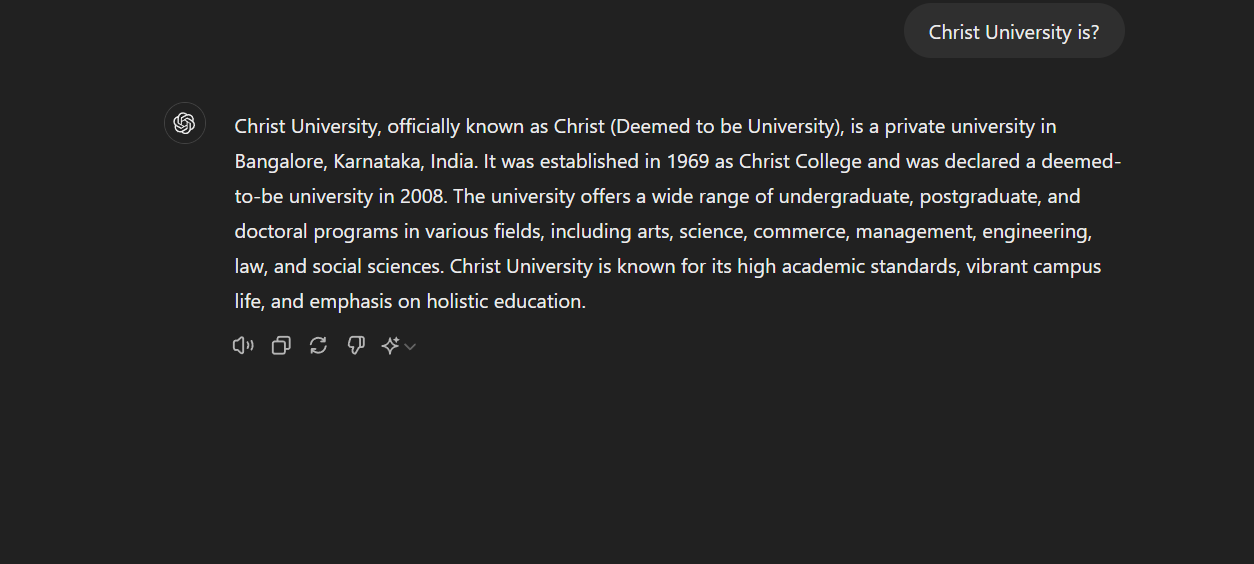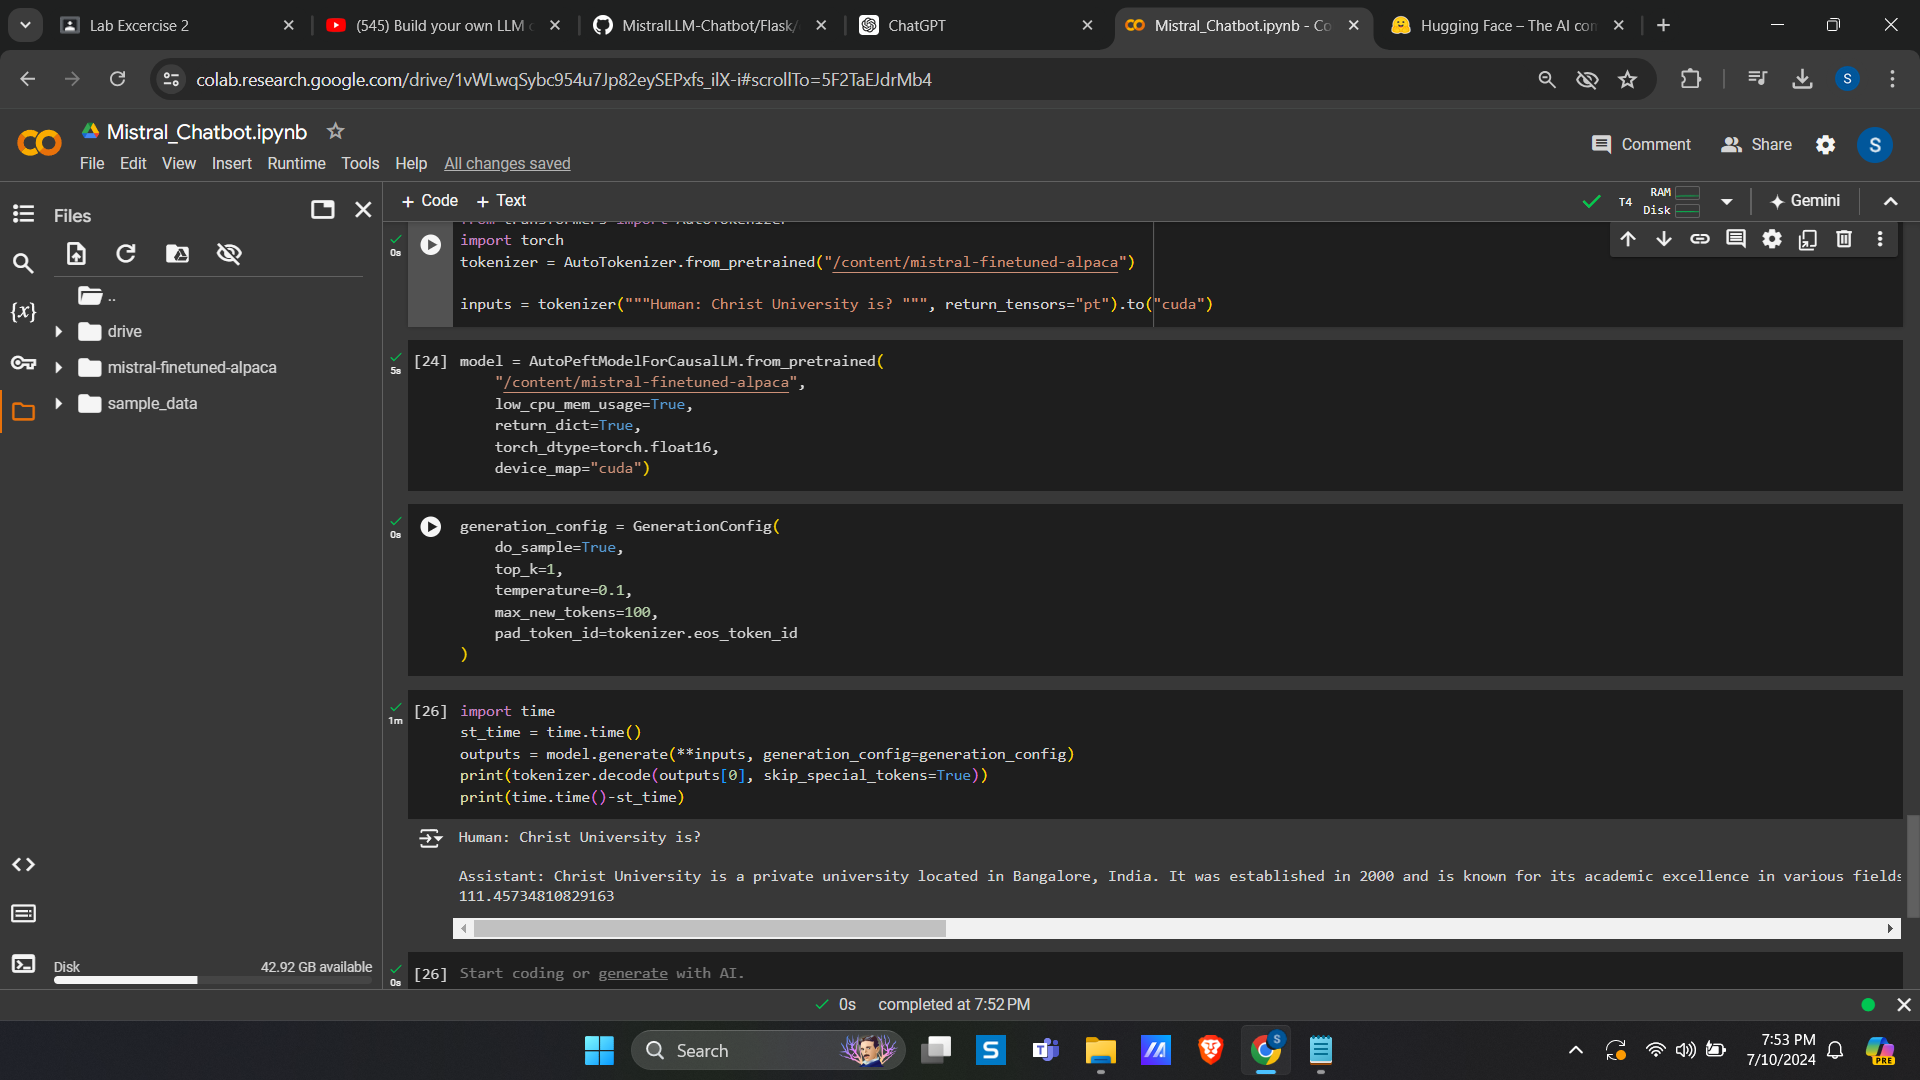

## Prompt2: Provide steps to prepare Gulab Jamun

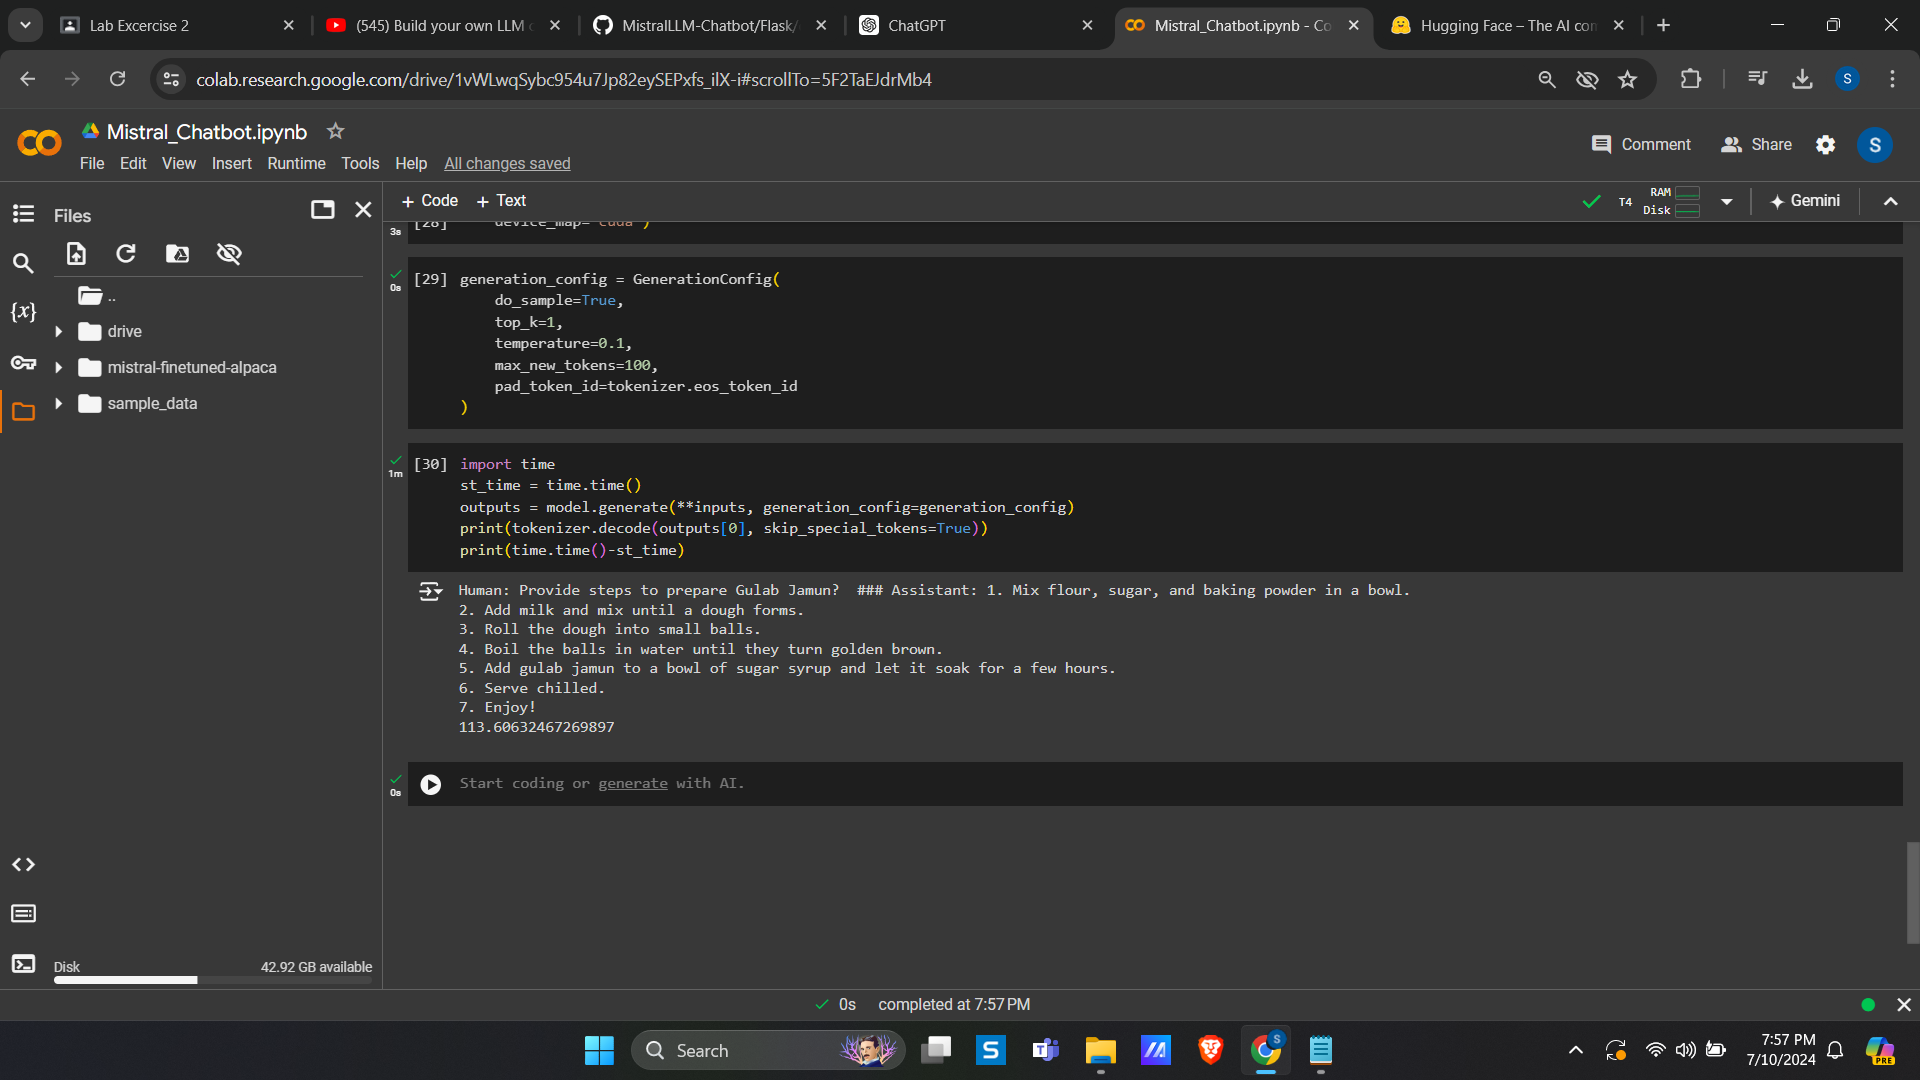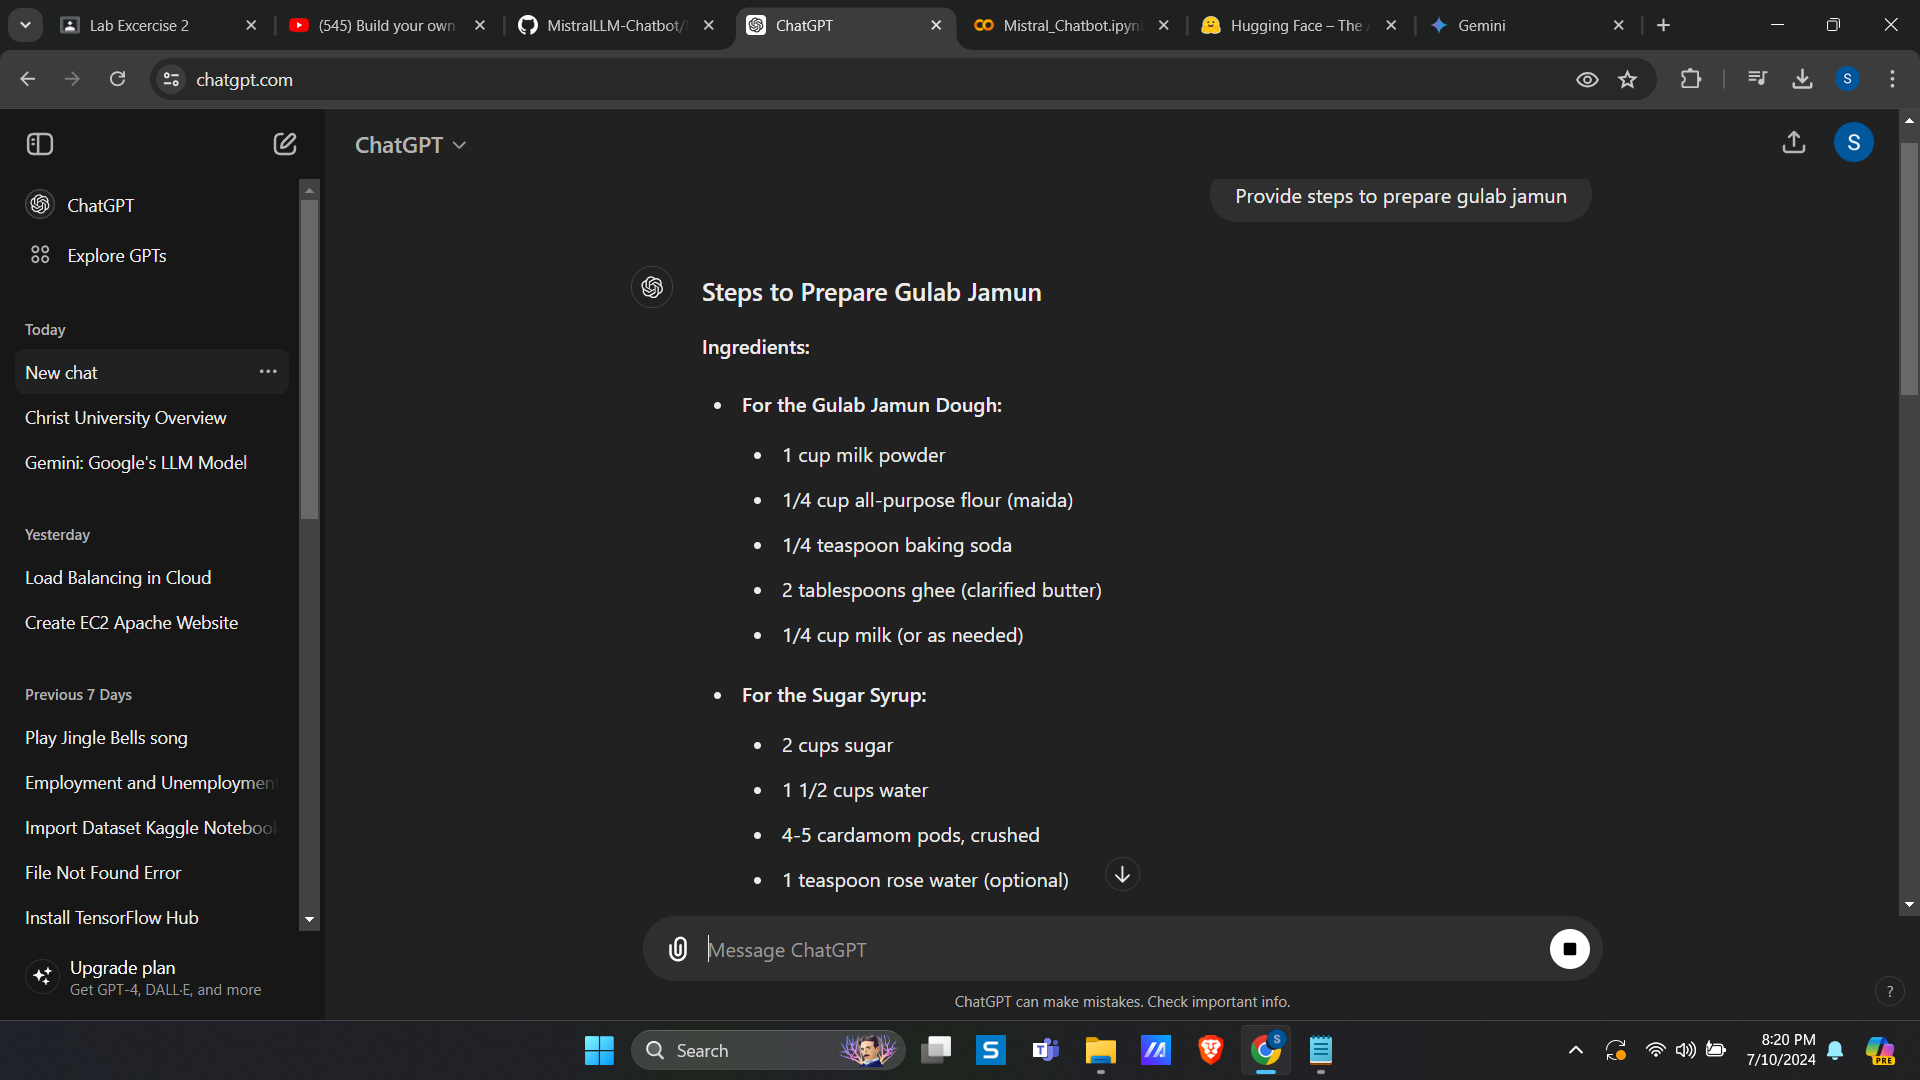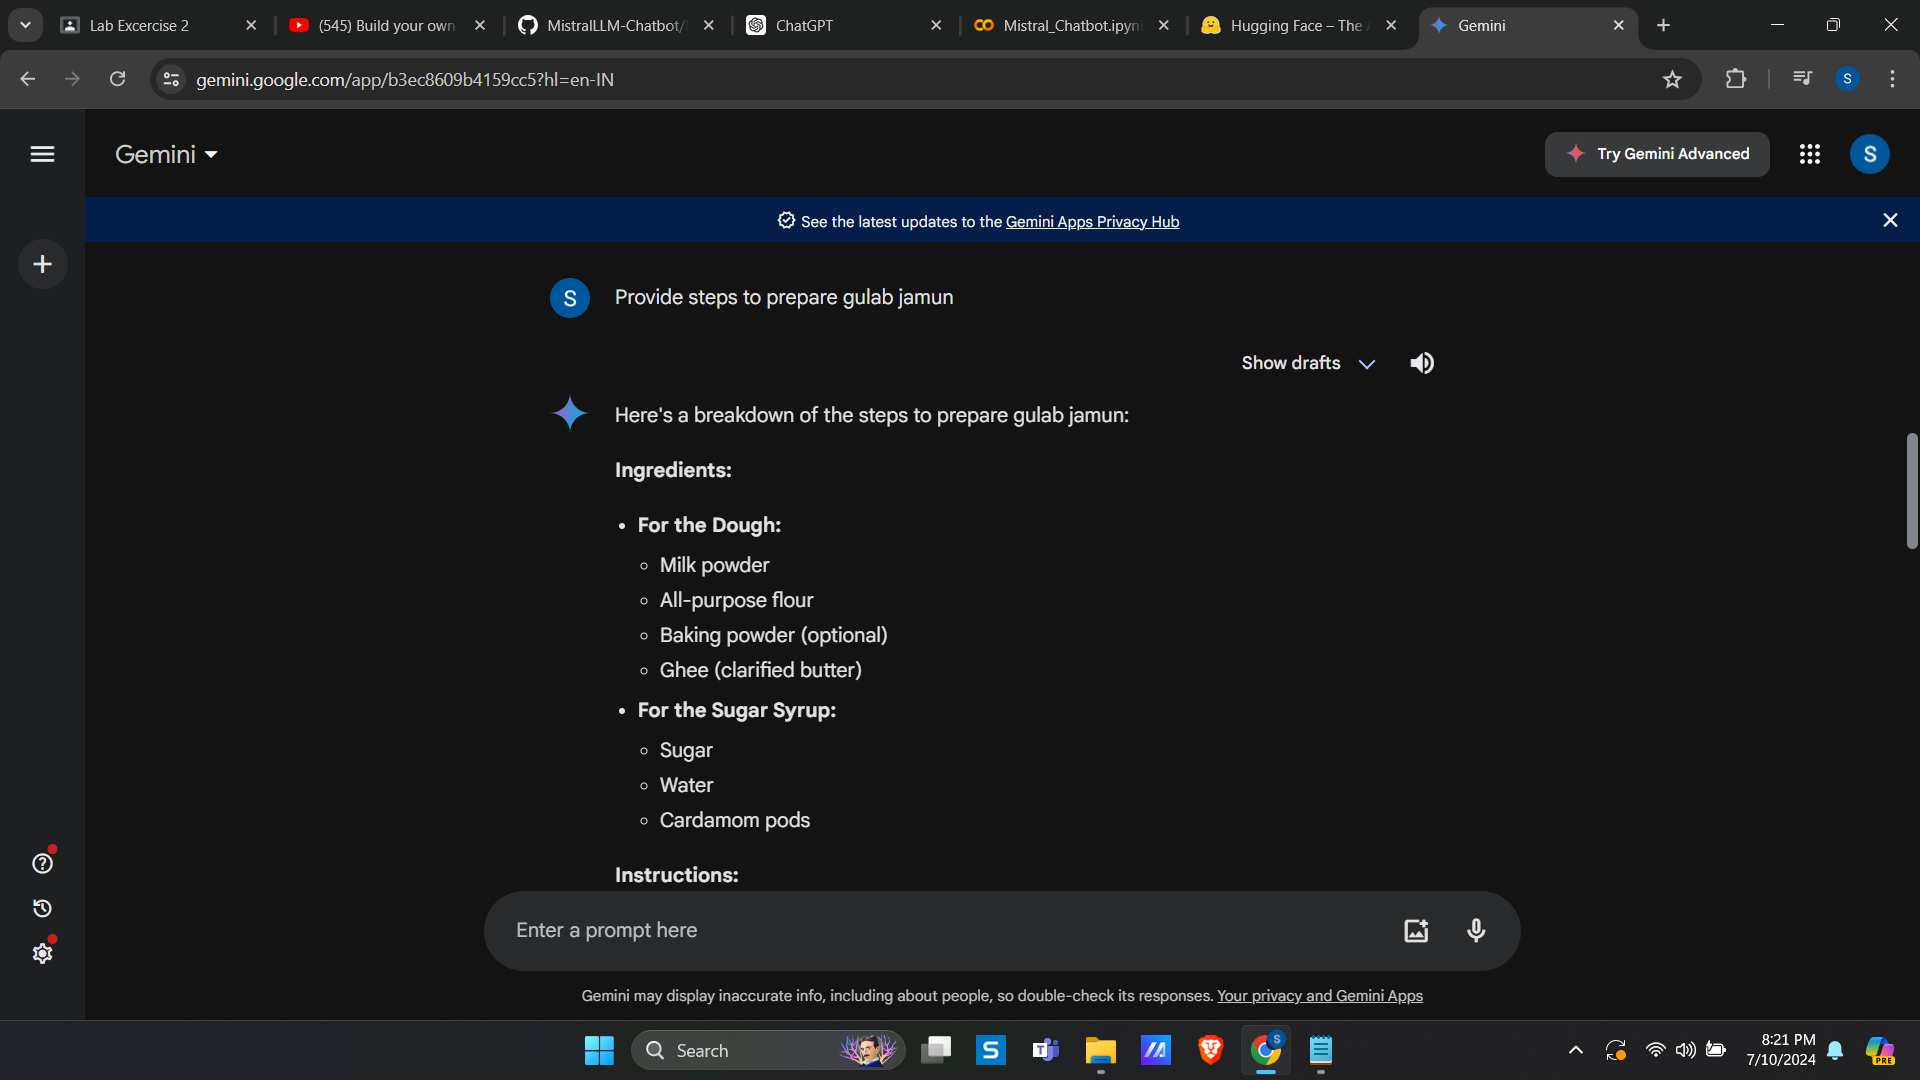

## Prompt3: What is difference between Decriminative AI and Generative AI?

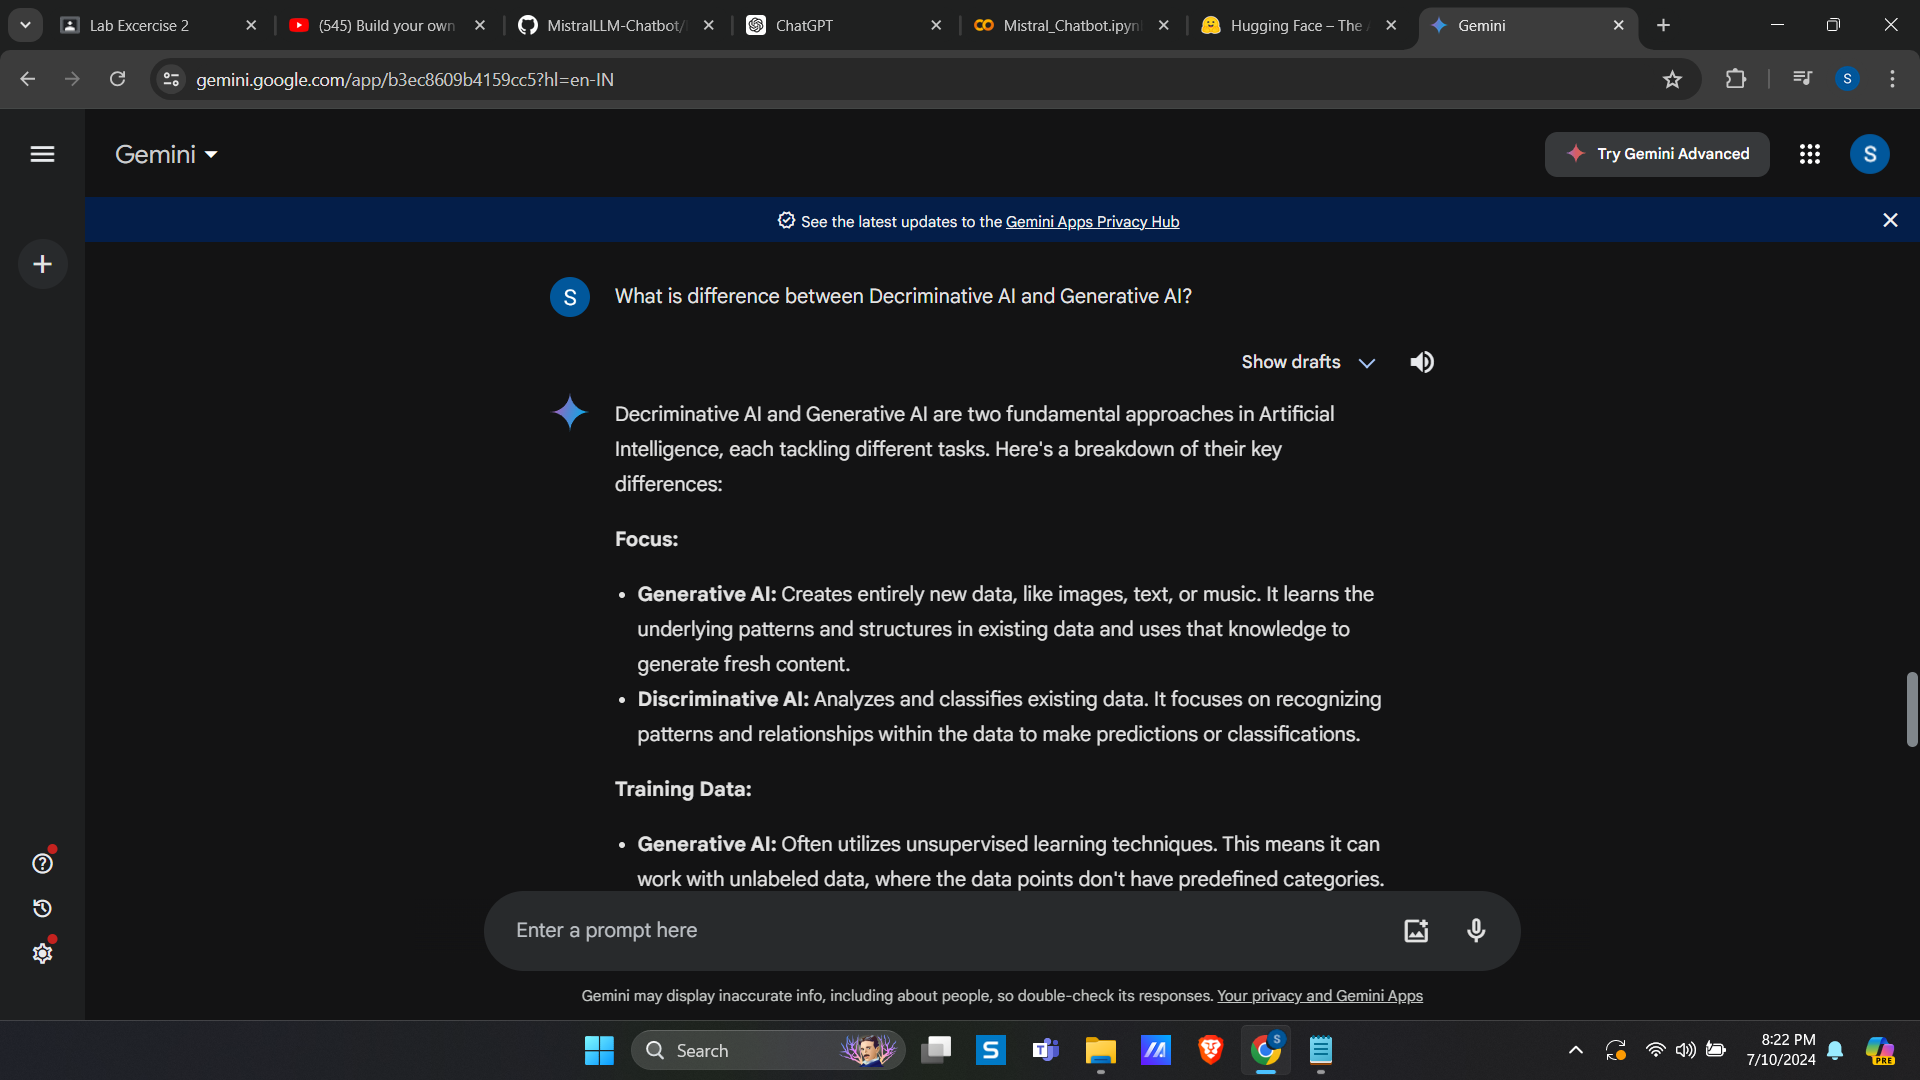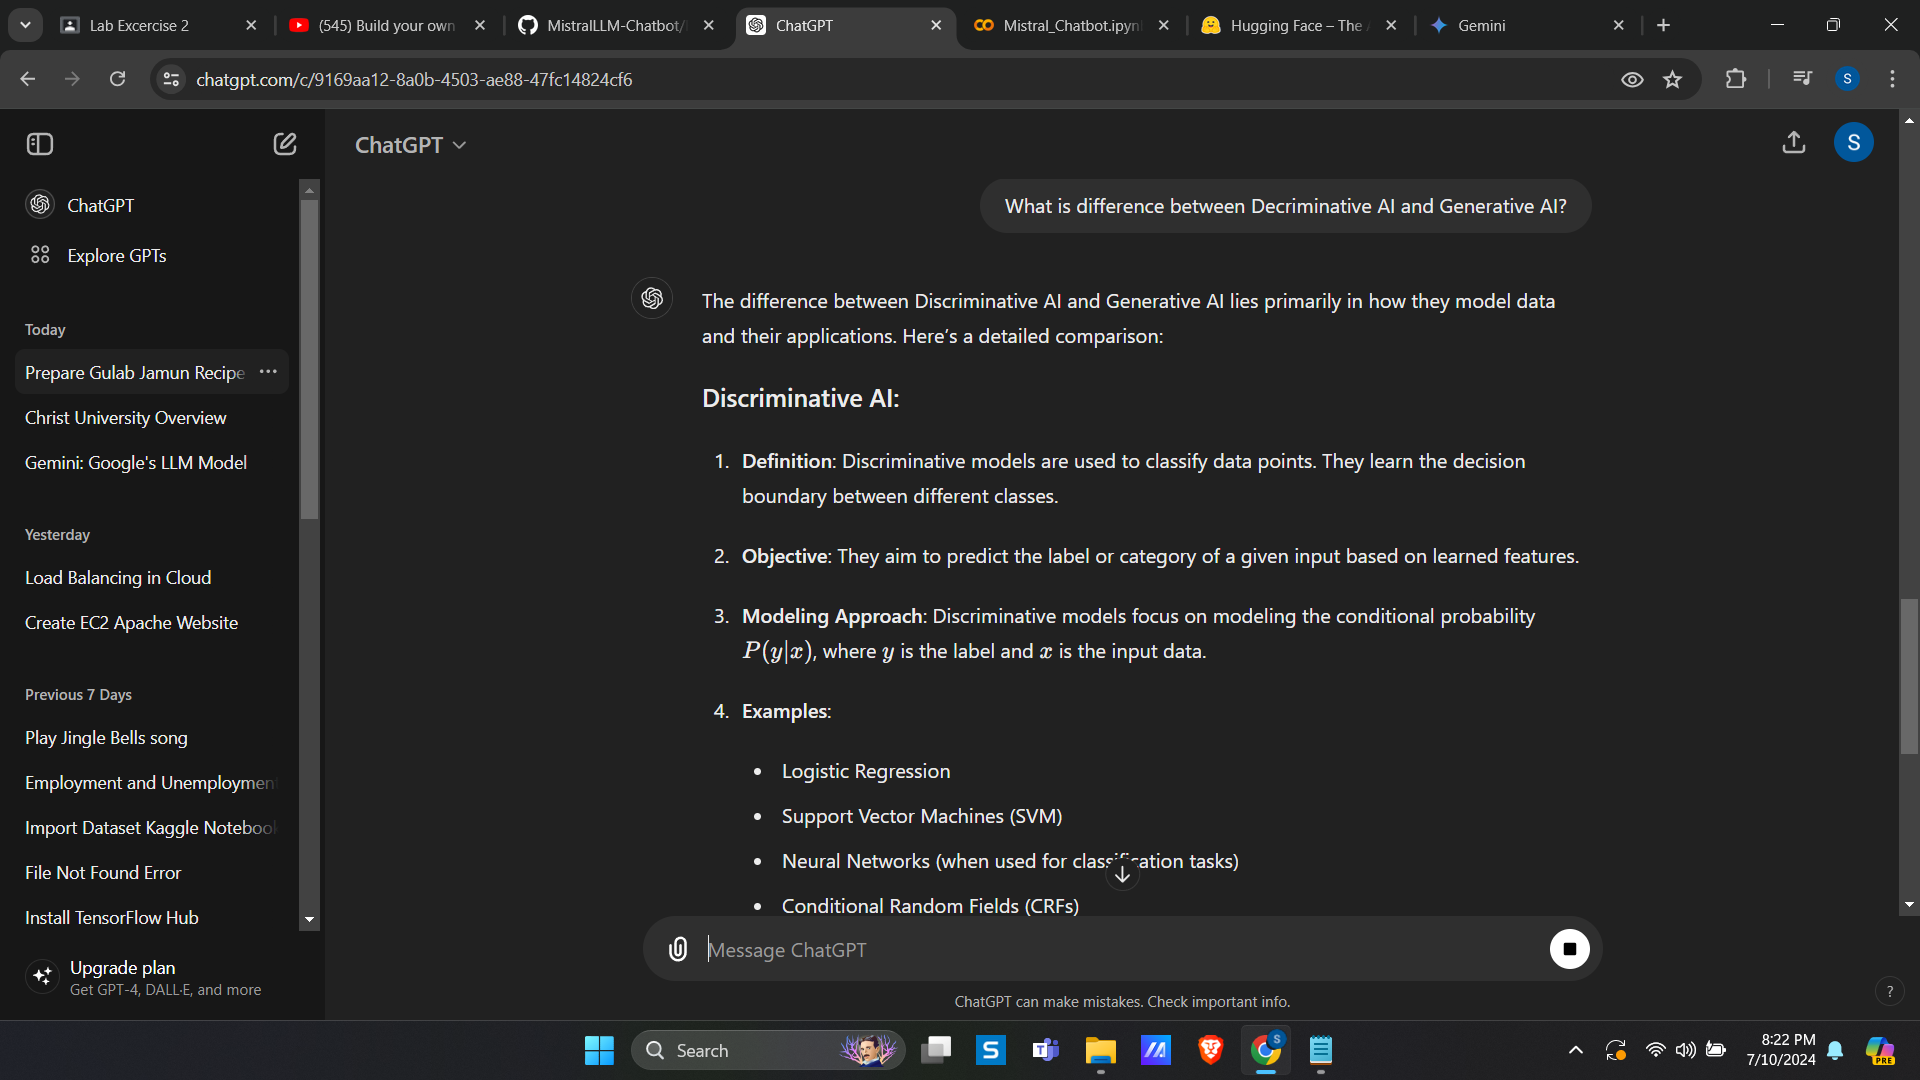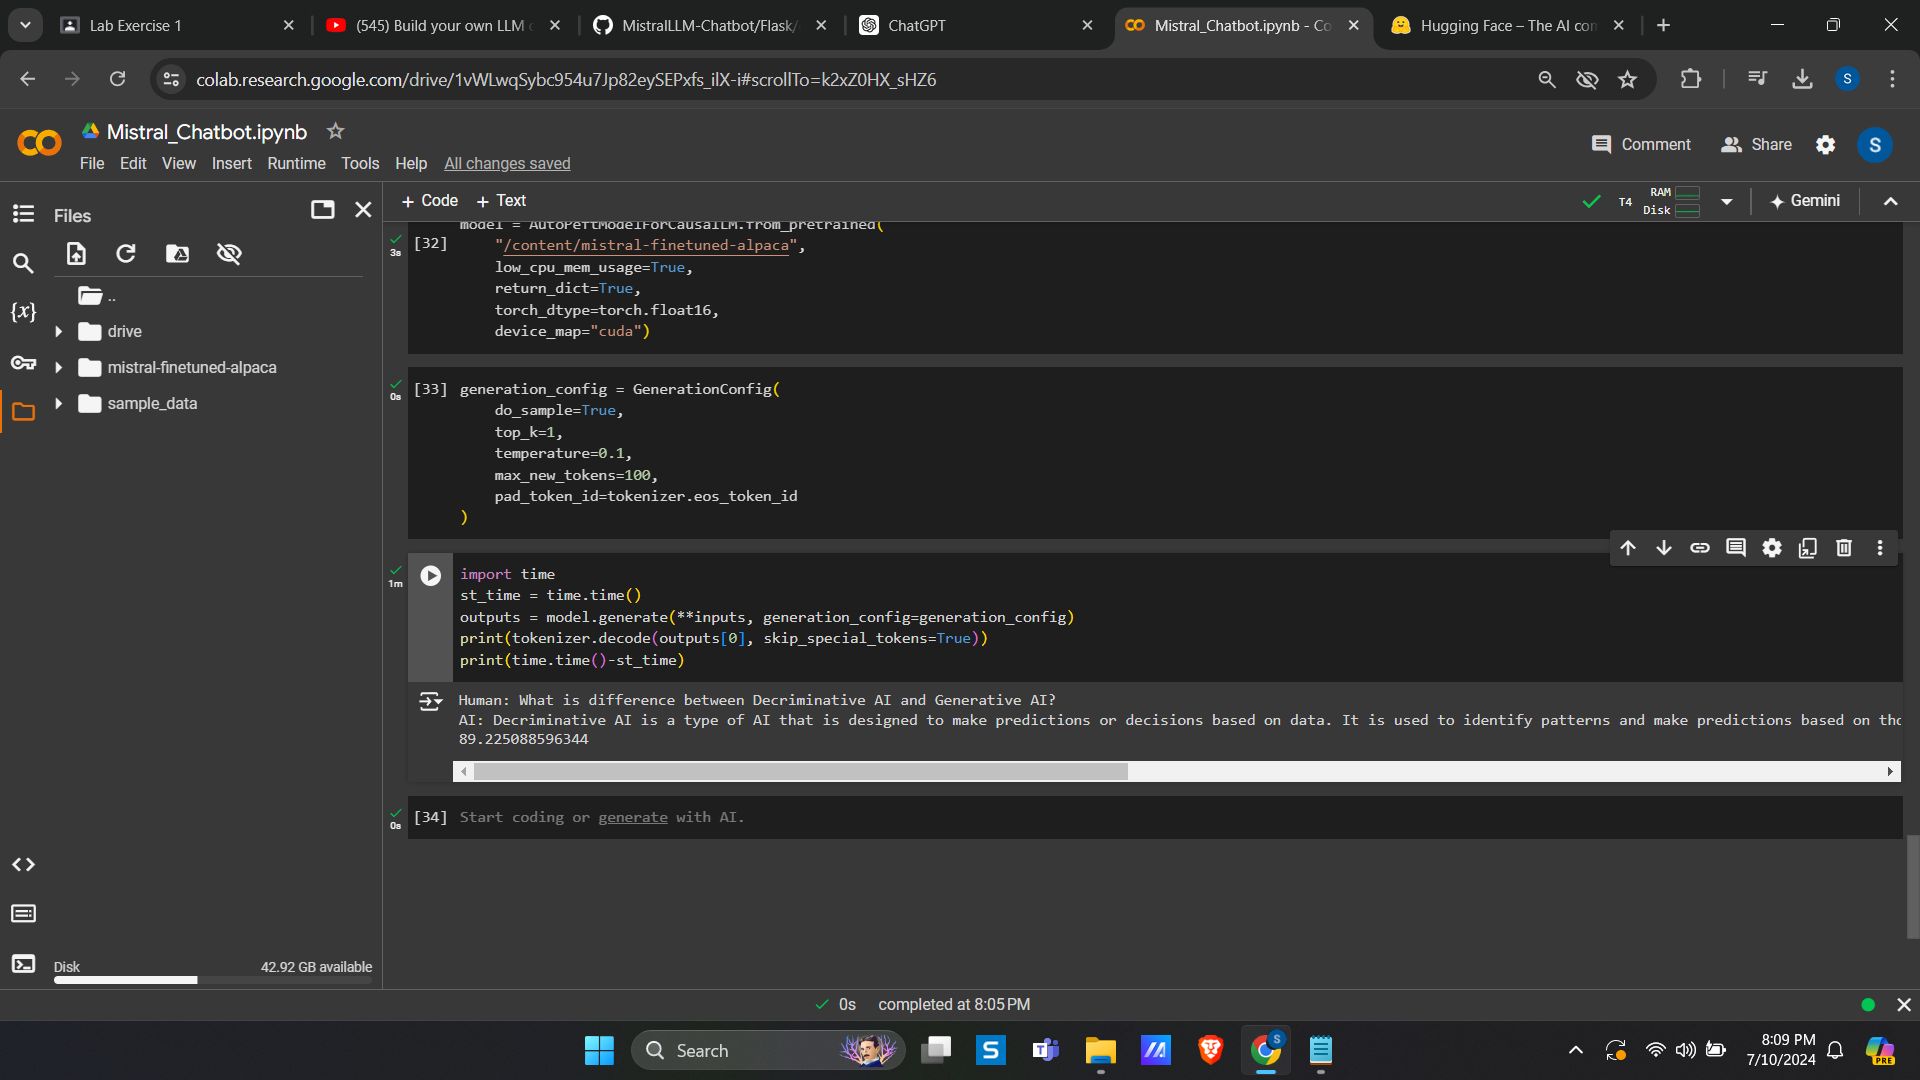